In [101]:
from terratorch.cli_tools import LightningInferenceModel
import mlflow
import torch
import torch.nn as nn
from torchvision.models.segmentation import (
    deeplabv3_mobilenet_v3_large,
    DeepLabV3_MobileNet_V3_Large_Weights,
)
import lightning as L
import matplotlib.pyplot as plt

In [102]:
CONFIG = "teachers/hls_burn_scars_teacher/burn_scars_config.yaml"
CHECKPOINT = "teachers/hls_burn_scars_teacher/Prithvi_EO_V2_300M_BurnScars.pt"

In [103]:
inference_model = LightningInferenceModel.from_config(CONFIG, CHECKPOINT)
teacher = inference_model.model
datamodule = inference_model.datamodule

/home/mkoza/workspace/ml/distilprithvi/venv/lib/python3.12/site-packages/lightning/pytorch/cli.py:530: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--f=/run/user/1003/jupyter/runtime/kernel-v30a6e9ea46f4929d9f82f91576c5122c93b7c2c4a.json'], args=['--config', 'teachers/hls_burn_scars_teacher/burn_scars_config.yaml'].
Seed set to 2
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed
/home/mkoza/workspace/ml/distilprithvi/venv/lib/pytho

In [104]:
class DeepLabMobileNetV3Large(nn.Module):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.model = deeplabv3_mobilenet_v3_large(
            weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT,
        )
        self.model.backbone["0"][0] = nn.Conv2d(
            num_channels,
            16,
            kernel_size=(3, 3),
            stride=(2, 2),
            padding=(1, 1),
            bias=False,
        )
        self.model.classifier[4] = nn.Conv2d(
            256,
            num_classes,
            kernel_size=(1, 1),
            stride=(1, 1),
            padding=(0, 0),
            bias=True,
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class DistilPrithvi(L.LightningModule):
    def __init__(
        self,
        teacher,
        student,
        soft_loss_weight=1.0,
    ):
        super().__init__()
        self.teacher = teacher
        self.teacher.eval()
        self.teacher.requires_grad = False

        self.student = student
        self.soft_loss_weight = soft_loss_weight

        self.metrics = {
            "train": self.teacher.train_metrics,
            "val": self.teacher.val_metrics,
            "test": self.teacher.test_metrics[0],
        }

    def forward(self, x):
        return self.teacher(x).output
        # return self.student(x)["out"]

    def _step(self, batch, stage):
        x = batch["image"]
        y = batch["mask"]
        y_hat_s = self(x)
        y_hat_s_hard = y_hat_s.argmax(dim=1)
        loss = self.teacher.criterion(y_hat_s, y)

        self.metrics[stage].update(y_hat_s_hard, y)
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=False)

        return loss

    def _on_epoch_end(self, stage):
        metrics = self.metrics[stage].compute()
        self.log_dict(metrics, on_epoch=True, on_step=False)
        self.metrics[stage].reset()

    def training_step(self, batch):
        return self._step(batch, "train")

    def validation_step(self, batch):
        self._step(batch, "val")

    def test_step(self, batch):
        self._step(batch, "test")

    def on_train_epoch_end(self):
        self._on_epoch_end("train")

    def on_validation_epoch_end(self):
        self._on_epoch_end("val")

    def on_test_epoch_end(self):
        self._on_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

In [106]:
distilprithvi = DistilPrithvi(
    teacher=teacher,
    student=DeepLabMobileNetV3Large(
        num_channels=len(datamodule.output_bands),
        num_classes=datamodule.num_classes,
    ),
    soft_loss_weight=0.0,
)

In [107]:
trainer = L.Trainer(
    max_epochs=0,
)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [108]:
mlflow.pytorch.autolog()

with mlflow.start_run():
    trainer.fit(
        distilprithvi,
        datamodule,
    )
    trainer.test(
        distilprithvi,
        datamodule,
    )

2025/05/01 17:37:02 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 1.9.0 <= torch <= 2.6.0, but the installed version is 2.8.0.dev20250430+cu128. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.
2025/05/01 17:37:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mkoza/workspace/ml/distilprithvi/venv/lib/python3.12/site-packages/mlflow/pytorch/_lightning_autolog.py:465: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.9.0 and 2.5.0.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                     | Params | Mode 
-------------------------------------------------------------
0 | teacher | SemanticSegmentationTask | 324 M  | eval 
1 | student | DeepLabMobileNetV3Large  | 11.0 M | train
----------------

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=0` reached.


2025/05/01 17:37:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0.dev20250430+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.8.0.dev20250430' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/05/01 17:37:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Test metric               ┃              DataLoader 0              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/Multiclass_Accuracy        │           0.9831123352050781           │
│        test/Multiclass_F1_Score        │           0.9831124544143677           │
│     test/Multiclass_Jaccard_Index      │           0.9168614149093628           │
│  test/Multiclass_Jaccard_Index_Micro   │           0.9667857885360718           │
│               test/loss                │          0.051870208233594894          │
│   test/multiclassaccuracy_burn_scar    │           0.9355161786079407           │
│   test/multiclassaccuracy_not_burned   │           0.9886535406112671           │
│ test/multiclassjaccardindex_burn_scar  │           0.8524360060691833           │
│ test/multiclassjaccardindex_not_burned │           0.981286883354187            │
└────────────────────────────────────────┴────────────────────────────────────────┘

In [18]:
def run_model_(x, model, datamodule):

    n = {}
    n["image"] = x
    x = datamodule.aug(n)["image"]

    pred = model(x)
    pred = pred.output

    y_hat = pred.argmax(dim=1)

    return y_hat


def display_mask(x):
    plt.imshow(x, cmap="gray")
    plt.axis("off")
    plt.show()

In [19]:
def display_mask(x):
    plt.imshow(x, cmap="gray")
    plt.axis("off")
    plt.show()

torch.Size([6, 512, 512])


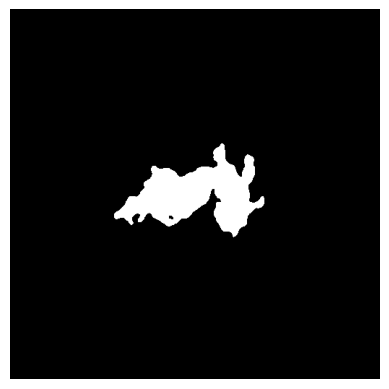

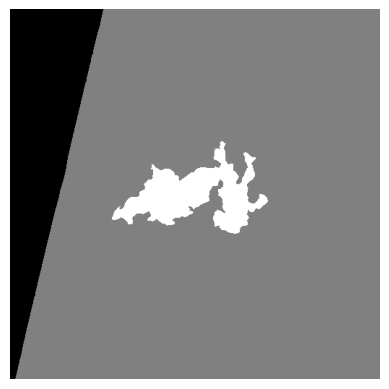

In [20]:
torch.seed()
teacher.eval()
datamodule.setup("test")
idx = torch.randint(0, len(datamodule.test_dataset), (1,)).item()
input_data = datamodule.test_dataset[idx]["image"]
mask = datamodule.test_dataset[idx]["mask"]
filename = datamodule.test_dataset[idx]["filename"]
print(input_data.shape)
input_data = input_data.unsqueeze(1).unsqueeze(0)

if input_data.mean() > 1:
    input_data = input_data / 10000  # Convert to range 0-1

pred = run_model_(
    input_data,
    teacher,
    datamodule,
)

display_mask(pred.squeeze(0).squeeze(0))
display_mask(mask.squeeze(0).squeeze(0))